##### Packages

In [1]:
using Plots, DifferentialEquations, Distributions, Random, LaTeXStrings, DataFrames, GLM, ProgressBars

##### First functions 

In [2]:
# Define CR dynamics for DifferentialEquations 

function CR!(dx,x,p,t)

    N,M,R = p
    dx[1:N] = x[1:N].*(R*x[1+N:N+M])
    dx[N+1:N+M] = -x[1+N:N+M].*(transpose(R)*x[1:N]) 
    
end
 
# Resource consumption 

function random_mat(N,M,S,Amag)

    A = rand(Float64, N*M);
    A[A .< S] .= 0;
    # since it's difficult to make a logical mask for a matrix i decided to use instead a flattened vector that i will 
    # reshape after the condition has been satisfied
    A = reshape(A, (N,M));
    # return A
    return A*Amag*N*M*M/sum(A)

end

# Defining initial conditions for X and Y for the first dilution cycle since in the successive both X0 and Y0 will 
# follow a a specific dynamics due to Y0 markov chain

function Y0s_fun(M,k,σ,steps,Ymag)
  
    Y0 = rand(M);
    Y0 /= sum(Y0);
    Y0 *= Ymag;

    Y0s = zeros((M,steps));
    Y0s[:,1] = Y0;

    for i in 2:steps
        tmp = Y0s[:,i-1] + σ*randn(M).*Y0 - k*(Y0s[:,i-1] - Y0)
        Y0s[:,i] = @. abs(tmp)
    end
    return Y0s
end

function Y0s_fun1(M,σ,steps,Y0)
  
    Y0s = zeros((M,steps));
    Y0s[:,1] .= Y0;

    for i in 2:steps
        tmp = Y0 .+ σ*randn(M)*Y0
        Y0s[:,i] = @. abs(tmp)
    end
    return Y0s
end

# the latter is a cicle that determines the initial values of Y0 for each cycle. Recall that there are two different 
# time scales: the first one concerns the CR dynamics (t=1:20 steps) while the second ranges the dilution cycles 

Y0s_fun1 (generic function with 1 method)

~~As we can see in the following cells there is a problem of mismatch in terms of the growth of consumers in each step of a dilution cycle. We would expect that the growth rate, at least in the first steps of the dilution cycle, were larger than a fraction of the dilution factor (like the 5%) but it's not. Consumers tend to grow 1% w.r.t the previous step.~~
##### Errata corrige
The growth ratio depends on the available amount of resources in the environment. Indeed we see that in a previous version of the code we used as $Y_i$ initial condition a bad normalized kind of resources and the behavior was like the one depicted above, that is the growth factor was smaller than 1%.

Findss function determined after how many dilution steps species abundances reach an approximate steady state. In implementing the function the first result was that consumers reach a steady state in about six up to eight dilution steps. There was a problem however in the amount of final resources at each dilution step. They became negative after only four time points. It means that we have to decrease the time span corresponding to each integration step or find automatically when resources become negative and stop integration at that point. The problem was found because when implementing this filter for breaking the dilution cycle when solutions become less than zero `((any(sol_mat[j] .< 0) == true) || (any(res_mat[j] .< 0) == true)) && break`. It happens that everytime the code was run then the cycle had stopped already at the first step. 

The solution we decided to use is to run a callback of `DifferentialEquations` library that terminates the integration loop in the exact integration time step when resources are negative.

In [3]:
# let's try to implement d diluition cycles from scratch. 
# We see first of all that p and tspan are constant vectors
# then we have to realize that X0s, for each cycle, must contain the information about the previous cycle therefore 
# we have to keep in memory all the solutions 

function findss(N,M,R,D,steady_steps,tspanf,Y0s;cons = true,ss = true)
    # add documentation for the function most of all for the two keyword arguments cons and ss!!!!!
    p = [N,M,R]
    tspan = (0.,tspanf)
    change_thresh = 0.05
    X0s = zeros((N,steady_steps+1));
    # columns are initial conditions the same way as Y0s, since we are going to initiate for each iteration the initial 
    # initial condition of the next one we need steps+1 columns even if the 101th won't be used 
    X0s[:,1] = ones(N)/N*100/D;
    sol = [[] for i=1:steady_steps]
    res = [[] for i=1:steady_steps]

    time_series = [[] for i=1:steady_steps]
    sol_mat = Matrix{Float64}[]
    res_mat = Matrix{Float64}[]

    for  j in 1:steady_steps 
        X0 = X0s[:,j]
        Y0 = Y0s 
        XY0 = vcat(X0,Y0)

        function positivedomain(u,t,integrator)
            any(integrator.u[(N+1):(N+M)] .< 10e-6) == true
        end
        
        # function terminate_zeroing!(integrator)
        #     terminate!(integrator)
        # end
        
        function zeroing!(integrator)
            integrator.u[(N+1):(N+M)][integrator.u[(N+1):(N+M)] .< 10e-6] .= 10e-6
        end

        aborted_res = DiscreteCallback(positivedomain,zeroing!)
        prob = ODEProblem(CR!, XY0, tspan, p, callback = aborted_res)
        sol_tmp = solve(prob, alg_hints=[:stiff]);
        
        # after having solved the problem let's memorize in X0s the consumers abundances and dilute them for setting the 
        # initial conditions
        
        X0s[:,j+1] = sol_tmp.u[length(sol_tmp.u)][1:N]/D
        
        # what are we doing here with this loop fusion? we are selecting the first N components of the solutions of the 
        # ode and then memorize them into each element of the vector sol. Sol therefore has steady_steps components or 
        # less if the approximate steady state condition is met and each of them contains the consumers abundances time 
        # series  

        sol[j] = sol_tmp.u
        res[j] = sol_tmp.u
        sol[j] = [sol[j][i][1:N] for i in 1:length(sol[j])]
        res[j] = [res[j][i][N+1:(N+M)] for i in 1:length(res[j])]
 
        # time_series doesn't need the previous filter of sol concerning consumers N since for each N+M solutions 
        # (one component of the sol vector) there is only one vector of time; that is we don't have to filter 
        # the consumers out because time is in common for both them and resources
        time_series[j] = sol_tmp.t
        
        tmp = zeros(length(sol[j]),N)
        for i in 1:length(sol[j])
            tmp[i,:] = sol[j][i]
        end
        push!(sol_mat,tmp)

        # for the purpose of having as a result a matrix with (timepoints,N) rows and columns for easy plots
        tmp_res = zeros(length(res[j]),M)
        for i in 1:length(res[j])
            tmp_res[i,:] = res[j][i]
        end
        push!(res_mat,tmp_res)
    
        # in order to reach a steady state we impose that the fraction of change in the abundance of consumers between  
        # two subsequent initial points of the dilution step should be less than 100% + 5% 
        print("$j ")
        ss == true && j >= 1 && sum((X0s[:,j+1]./X0s[:,j] .- 1) .< 0.05) == length(X0) && break 
        # here we verify that the sum of the boolean vector that results from the inequality condition is equal to 
        # the length of sol; that is element wise condition is verified for all the components of the difference vector
    end
    # print("$j dilution steps have been processed \n")
    filt = [i for i in 1:length(sol) if sol[i] != []] 
    # filtering those components of the array that are non "Any" in order to see how many steps of dilution were necessary
    # for reaching the approximate steady state of consumers
    # sol = sol[filt]
    # it's not necessary anymore since the function doesn't return sol but sol_mat, it could be chosen by the user 
    # if it wants sol or sol_mat as a result of the function  
    time_series = time_series[filt]

    return [sol_mat,res_mat],time_series

end

findss (generic function with 1 method)

In [4]:
# Second version of findss  

function findss1(N,M,R,D,Y0s; cons = true, ss = true)
    
    p = [N,M,R]
    tspan = (0.,20.)
    steady_steps = 20
    change_thresh = D*0.05

    # ---Initial conditions at first cycle of reservoir---
    X0 = ones(N)/N*100/D  
    Y0 = Y0s 
    XY0 = vcat(X0,Y0)

    #---Definition of the ode problem and solution of the first dilution step---
    prob = ODEProblem(CR!, XY0, tspan, p);
    sol_tmp = solve(prob, alg_hints=[:stiff])
    
    #---Instanciation of the main variables useful for memorizing the solutions time series for each dilution step---
    sol = [[] for i=1:steady_steps]
    time_series = [[] for i=1:steady_steps]
    sol_mat = Matrix{Float64}[]

    #---Dilution steps---
    ratios_last = sol_tmp.u[length(sol_tmp.u)][1:N]./X0

    for j in 1:steady_steps 
        X0 = sol_tmp.u[length(sol_tmp.u)][1:N]/D  
        XY0 = vcat(X0,Y0)
        prob = ODEProblem(CR!, XY0, tspan, p);
        sol_tmp = solve(prob, alg_hints=[:stiff])

        #---Steady state condition selecting only the consumers 1:N in the ode solution---
        ratios_this = sol_tmp.u[length(sol_tmp.u)][1:N]./X0
        ss == true && sum((@. abs(ratios_this - ratios_last)) .< change_thresh) == length(X0) && break
        # ATTENZIONE CHE SE LO FACCIO IN QUESTO MODO RITROVO I MIEI RISULTATI 
        # ss == true && sum((ratios_this./ratios_last .- 1) .< 0.05) == length(X0) && break

        ratios_last = ratios_this

        #---Memorizing solutions in an array of sol.u and then making it an array of matrices since each step consist 
        # of t rows and N columns---
        sol[j] = sol_tmp.u 
        if cons == true  
            sol[j] = [sol[j][i][1:N] for i in 1:length(sol[j])]
        end
        time_series[j] = sol_tmp.t
        
        tmp = zeros(length(sol[j]),N)
        for i in 1:length(sol[j])
            tmp[i,:] = sol[j][i]
        end
        push!(sol_mat,tmp)
        print(j," dilution steps accomplished \n")
        
    end

    #---Filtering those components of the array that are different from "Any", that is selecting only those components 
    # in sol that correspond to the dilution steps before the approximate steady state---
    filt = [i for i in 1:length(sol) if sol[i] != []] 
    time_series = time_series[filt]

    return sol_mat,time_series

end

findss1 (generic function with 1 method)

##### Find one dilution cycle solution for consumers with (N,M,S,$\sigma$,k) = (50,30,0.1,0.2,0.8)

In [5]:
N = 10 
M = 10
S = 0.1
σ = 0.2
k = 0.8
D = 200
Amag = 0.001 
Ymag = 100
steps = 1000
steady_steps = 20
tspanf = 20

R = random_mat(N,M,S,Amag)
Y0s = Y0s_fun(M,k,σ,steps,Ymag)
# only the first column since the others will be useful when calculating the consumers time series 
sr,t = findss(N,M,R,D,steady_steps,tspanf,Y0s[:,1]);

1 2 3 4 5 6 

##### Steps of one dilution cycle plot 

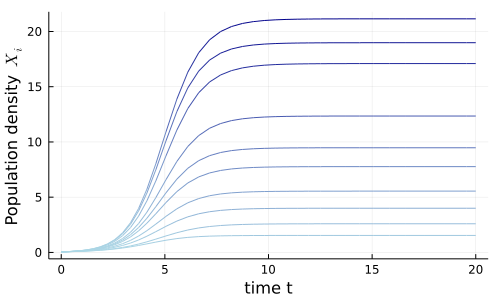

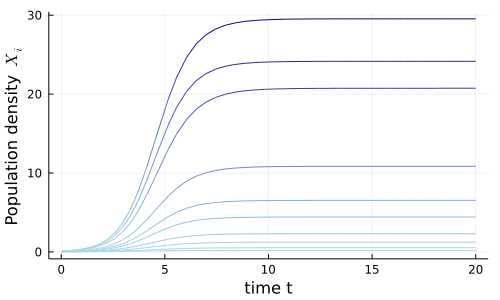

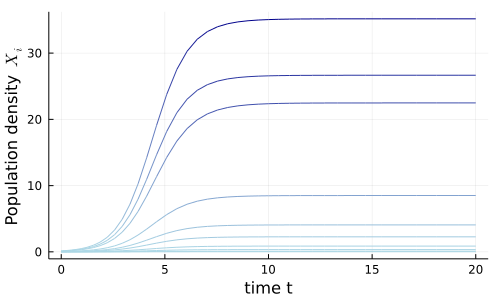

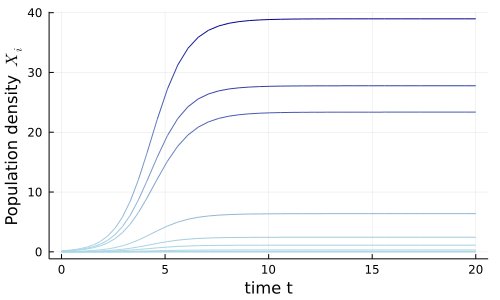

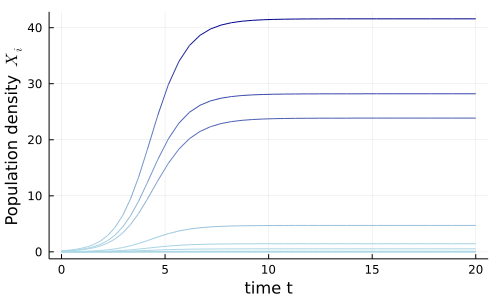

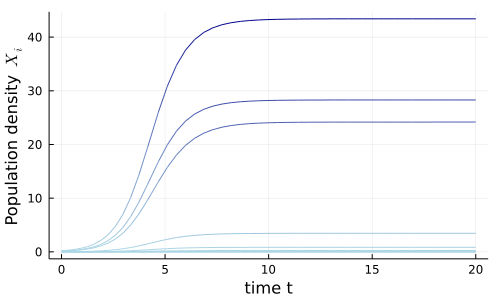

In [7]:
# in order to make some exaustive plots we can create a vector P whose elements are stored for each step
# of the dilution cycle and then plot those components
s = sr[1]
P = []
for i in 1:length(s)
    push!(P,plot(t[i],s[i], legend=false, size = (500,300), ylabel = "Population density"*L"\ \ X_i", xlabel = "time t",
                 color=:blues, line_z=s[i])) # this is useful for setting the gradient color palette wrt y axis values 
    display(P[i])
end

##### $X_{0,j}$ plot in order to notice how the initial conditions change from one step of the dilution cycle to the subsequent

The condition requested for the approximate steady state has been met

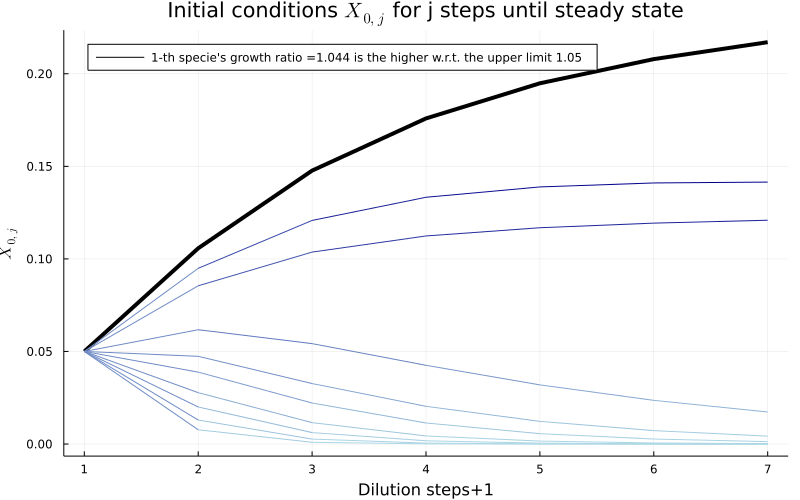

In [10]:
function initial_cond(s,D)
    X0j = hcat([s[j][1,:] for j in 1:length(s)]...)
    X0j = transpose(hcat(X0j,s[end][end,:]./D))
    return X0j
end
# in this matrix each column is made of the initial points X0j for j in 1:steady_steps that i can plot in order to see 
# whether the condition about the steady state has been reached
X0j = initial_cond(s,D)
growth_ratios_fin = []
for i in 1:N 
    push!(growth_ratios_fin,X0j[end,i]./X0j[end-1,i])
end

if sum(growth_ratios_fin .< 1.05) == N
    print("The condition requested for the approximate steady state has been met")
end

ix = findmax(growth_ratios_fin)[2] 
max_gr = round(findmax(growth_ratios_fin)[1], digits=3) 
# index of the maximum growth ratio before the approx steady state has been reached 
plot(X0j[:,ix],size=(800,500),label="$ix-th specie's growth ratio =$max_gr is the higher w.r.t. the upper limit 1.05",
     legend=:topleft,linewidth=4,ylabel=L"X_{0,j}",
     xlabel="Dilution steps+1",title="Initial conditions "*L"X_{0,j}"*" for j steps until steady state",
     xticks=[1:(length(s)+1)...],color=:black)

plot!(X0j[:,[1:(ix-1);(ix+1):size(X0j,2)]],label="",color=:blues,line_z=X0j[:,[1:(ix-1);(ix+1):size(X0j,2)]],colorbar=false)
# label="" suppresses those lines we are plotting in the second command plot! that we are not interested in
# there is also a shorthand to write multiple ranges for selecting array elements indices 
# savefig("steady_st.png")

By plotting $X_{0,j}, \ \ j=1,\dots,\text{ss}$, where ss is those number of steps that reproduce the approximate steady state, we can see that there are few species that each dilution step increase their abundances before being diluted. The remaining part of species, on the other hand, decrease and at the last step are almost extinguished. We can see also that during the last step those initial conditions that incerased in the previous steps, now don't change as much as before and their ratio shouldn't overcome the 5% as requested from the `findss()` function.

*Be careful!* the `growth_ratios` vector is made of `length(time_steps)`+1 components since we are comparing the initial conditions of each step; that is when we build the final step solution its initial conditions are the $j$-th while its final abundances divided by the dilution factor D are the $j+1$-th. It's only when the growth ratio condition is met during the last step between the above mentioned quantities that we can say that the dilution has reached the approximate steady state in those number of steps.

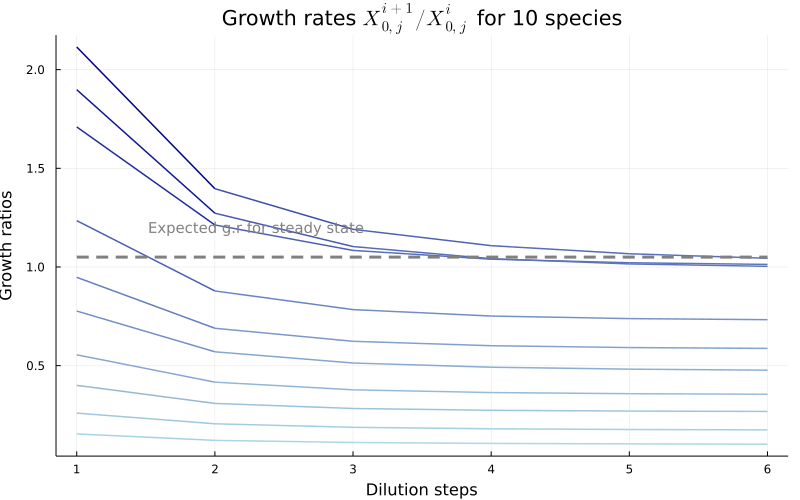

In [19]:
# let's graph the growth ratios of each species 

growth_ratios = X0j[2:end,:]./X0j[1:(end-1),:] 
# Recall that here X0j has steady_steps + 1 rows since we are considering the initial conditions of the subsequent dilution
# step we stopped right before for reaching the condition, that is the final values of consumers abundances divided by the 
# dilution factor!

n_gr = N

plot(growth_ratios,legend=false,size=(800,500),xlabel="Dilution steps",ylabel="Growth ratios",
     title="Growth rates "*L"X_{0,j}^{i+1}/X_{0,j}^i"*" for $n_gr species",color=:blues,line_z=growth_ratios,linewidth=1.5)

plot!([1:(size(growth_ratios,1))...],[1.05 for i in 1:(size(growth_ratios,1))],linewidth=3,color="grey",linestyle=:dash) 

annotate!((2.3,1.2,("Expected g.r for steady state",10,"grey")))
# savefig("growth_rates.png")

##### Consumer time series statistics

Let's compute and plot now the relative abundances at sampling time $T$ obtained from the final species abundances at steady state. The model maps a set of fluctuating resource amounts $Y_{j,0}(T)$ to a time series of consumer relative abundances $X_i(T)$.

In [22]:
function final_cond(s)
    return transpose(hcat([s[i][end,:] for i in 1:length(s)]...))
end

final_cond (generic function with 1 method)

In [29]:
# plot() function represents, starting from a matrix with NxM dimension, each column against the indices 
# coming from the length of those columns. We end up then with M lines.

#---Parameters of the simulation---

N = 10 
M = 10
S = 0.1
σ = 0.2
k = 1
D = 200
Amag = 0.001 
Ymag = 100
Ȳ = 50
steps = 1000
steady_steps = 20
tspanf = 20

xss = zeros(steps,N)
Y0j = Y0s_fun(M,k,σ,steps,Ymag)
# Y0j = Y0s_fun1(M,σ,steps,Ȳ)
R = random_mat(N,M,S,Amag)
yss = zeros(steps,M)
consumers = [];
resources = [];
times = [];

In [30]:
for i in 1:steps
    sr,t = findss(N,M,R,D,steady_steps,tspanf,Y0j[:,i]);
    s = sr[1]
    r = sr[2]
    Xfj = final_cond(s)
    Yfj = final_cond(r)
    xss[i,:] = Xfj[end,:]./D
    yss[i,:] = Yfj[end,:]
    # step useful to normalize the abundances in order to plot then relative abundances 
    # xss[i,:] ./= sum(xss[i,:])
    # yss[i,:] ./= sum(yss[i,:])
    push!(consumers,s)
    push!(resources,r)
    push!(times,t)
end

1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 9 10 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 9 10 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 10 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 10 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 1 2 3 4 5 6 7 8 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 9 10 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 8 9 1 2 3 4 5 6 7 8 9 1

In [35]:
plot(xss,yaxis=:log,xlim=(0,100),legend=false,size=(800,500),line_z=log.(xss),color=:blues,linewidth=2.5,
     xlabel="Sampling time T",ylabel="Consumer rel abundances "*L" X_i")
# savefig("species_timeseries.png")

In [36]:
plot(yss,yaxis=:log,xlim=(0,100),legend=false,size=(800,500),line_z=log.(yss),color=:blues,linewidth=2.5,
     xlabel="Sampling time T",ylabel="Resources rel abundances "*L" Y_i")
# savefig("resources_timeseries.png")

In [37]:
plot(transpose(Y0j),yaxis=:log,xlim=(0,100),legend=false,size=(800,500),line_z=log.(transpose(Y0j)),color=:blues,linewidth=2.5,
     xlabel="Sampling time T",ylabel="Initial resource amount "*L" Y_{j,0}")
# savefig("initresources_timeseries.png")

In [38]:
means = [log10(mean(xss[:,i])) for i in 1:N]
vars = [log10(var(xss[:,i])) for i in 1:N]
data = DataFrame(X=(means),Y=(vars));
ols = lm(@formula(Y ~ X), data)
q = round(coef(ols)[1],digits=3)
m = round(coef(ols)[2],digits=3)
pred = q .+ m.*means

scatter(means,vars,color=:orangered,markersize=8,markerstrokewidth=0,label="")

plot!(means,pred,color=:black,linewidth=3,
      xlabel="Mean abundances "*L"\langle X_i \rangle",ylabel="Abu variances "*L" \sigma^2_{X_i}",
      label="Y=$q + $m X is the fitted line",legend=:topleft)
# savefig("taylor_law.png")

##### Mistake i realized i had made thanks to the $\Delta l$ abundances change distribution
When plotting that distribution i found out it was more likely a normal since in log-log plot it was displayed like a parabola. The error was originally made in the call of `findss` function many times, that is each call created a random interaction matrix `A` while of course the way consumers eat resources should stay the same during the small time scale of the process.

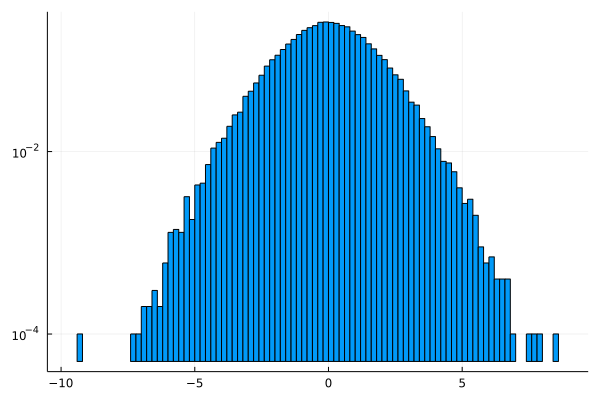

In [46]:
a = log.(xss[2:end,:]./xss[1:(end-1),:])
histogram([a...],legend=false,normalize=:true,yaxis=:log)

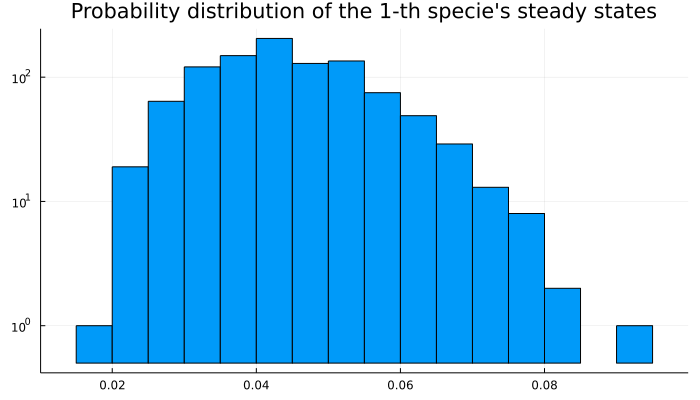

In [17]:
p = [histogram((xss[:,i]),density=:true,legend=false,title="Probability distribution of the $i-th specie's steady states",
               size=(700,400),yaxis=:log) for i in 1:N]
display(p[1])

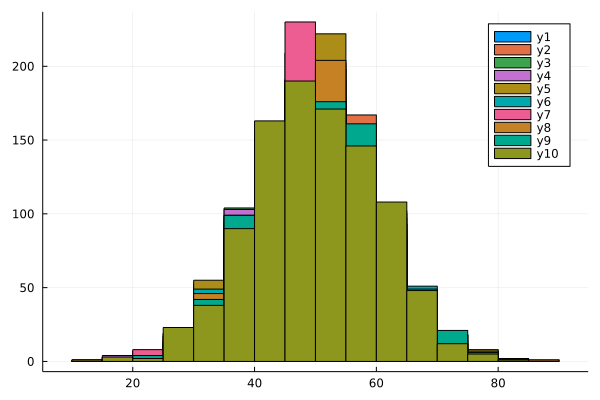

In [20]:
histogram(transpose(Y0j))

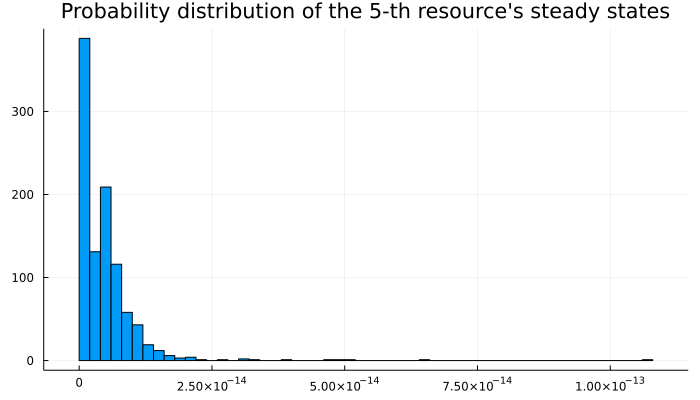

In [25]:
p1 = [histogram((yss[:,i]),density=:true,legend=false,title="Probability distribution of the $i-th resource's steady states",
               size=(700,400)) for i in 1:M]
display(p1[5])

~~Multiplicative noise inside the fluctuation of resources determines both in $Y_{0,j}$ and $X_{f,j}$ the tails in the probability distributions of the time series of each species while memory implies that these distributions are centered in zero (gamma distributions). Indeed we have a uniform random variable times a gaussian, that is the variance has its own variation each time step $T$ in a different scale. Furthermore the fact that the dilution steps are more than one implies that the centre of the distributions is shifted more to the left since species tend to be estinguished more frequently after more dilution steps. $Y_{0,j}$ and $X_{f,j}$ distributions for each species are similar only when the dilution step is one since the multiplicative noise appears without a sum both in X and Y; otherwise in X there would be a sum of as many components with the multiplicative noise.~~

If we compare one dilution step process, instead of more than one dilutions as in the standard and steady state case, to the same process but with only one realization and with stocasticity added subsenquently to the initial conditions of $Y_{0,j}$ and we plot the distribution of the final abundances points of each step we obtain the same distribution as having a lot of realizations with only one dilution step (imagine a vertical lot of realizations versus a long horizontal subsequent dilution steps). <br> 
- If we added stochasticity also to D (drawn from normal) we will find a long tailed distribution in the opposite direction since one divided a normal gives something similar to a log-normal. If D instead were drawn from a uniform distribution we would find the same long tailed distribution as before since one divided by a uniform is still a uniform distribution (D appears in $X_{f,j}$ markov chain in the denominator). 

The whole process tries to mimic the behavior in the human gut of bacteria that consume food eaten in a day (a time step T) and diluted by the portions of the gut that digest it (escrements are indicators of the presence of those bacteria); that is after some dilution steps, going through the gut, we will find a steady state of bacteria abundances (what does it mean however that resources are replenished each step with the same quantity?). The day after, $T+1$ time step, new resources are randomly eaten and the dilution process starts over again.  

let's see if the process with a serial dilution scheme corresponds to the one dilution step but with more realizations. There is a main difference in when we put the noise and when stationarity is reached. 
- if we consider the one step process with a lot of realizations we have stochasticity added in resources but consumers are not diluted for each realizations since they start as they were in the beginning. 
- if we consider the serial dilution process instead consumers are subsequently diluted for each step and noise in resources is added correspondently.  